In [36]:
import matplotlib.pyplot as plt
#matplotlib inline

import sys
sys.path.append('..')
from bedspring import *
import numpy as np



In [37]:
from mpl_toolkits.mplot3d import Axes3D

def plot_voltage_3d(l, xp=None, yp=None, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = []
    y = []
    
    if xp is None:
        for c in l.get_cell_list():
            x.append(c.x)
            y.append(c.y)
            #v.append(c.v)
    else:
        x = xp
        y = yp
        #v = [l.find_closest_cell(x=xp[i], y=yp[i]).v for i in range(xp.__len__())]

    X, Y = np.meshgrid(np.unique(np.sort(x)),np.unique(np.sort(y)))
    V = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            V[i,j] = l.find_closest_cell(x=X[i,j], y=Y[i,j]).v

   
    ax.plot_surface(X/1e3, Y/1e3, V, cmap='jet')
    ax.set_xlabel('X-dimension (um)')
    ax.set_ylabel('Y-dimension (um)')
    ax.set_zlabel('Voltage')
    ax.set_title('Voltage distribution on layer {} & Net {}'.format(l.name, l.net))
    # add colorbar
    m = plt.cm.ScalarMappable(cmap='jet')
    m.set_array(V)
    plt.colorbar(m,ax=ax)
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()
    
    return X,Y,V
    

In [38]:
#MRB Board
IRdrop = 0

t = 5.4*25.4e-6 # 2 2.7mil thick layers 
met_den = 0.7
rx_sheet = 1/4e7/t/met_den
print(rx_sheet)
ry_sheet = 1/4e7/t/met_den
l = layer(name='PWR',net='VLASER',lx=0,ly=0,ux=10e3,uy=80e3,dx=1e3,dy=1e3,rx_sheet=rx_sheet,ry_sheet=ry_sheet)
ld = load(l1=l, l2=None, lx=0,ly=15e3,ux=10e3,uy=80e3,iload=37)
src = sources(l1=l, l2=None, lx=0, ly=0, ux=5e3, uy=5e3, v=1.8)
s = system()
s.layers.append(l)
s.loads.append(ld)
s.sources.append(src)
s.arrange_nodes()
s.fill_matrix()
s.solve()
s.recover()
X, Y, V = plot_voltage_3d(l, filename='mrb_pwr.png')
print('Max Voltage: {}V'.format(np.max(V)))
print('Min Voltage: {}V'.format(np.min(V)))
print('Drop: {}mV'.format((np.max(V)-np.min(V))*1e3))
IRdrop += (np.max(V)-np.min(V))*1e3


0.00026038411865183516
Max Voltage: 1.7999999932962638V
Min Voltage: 1.7579114545552617V
Drop: 42.088538741002154mV


![alt text](mrb_pwr.png)

In [39]:
# Connector
current = 36.48 # From CLM Pinmap Strategy speradsheet
pin_res = 0.36 #mOhm
connector_drop = current*pin_res
IRdrop += connector_drop
print('Connector Drop: {}mV'.format(connector_drop))
print('Total IR Drop: {}mV'.format(IRdrop))

Connector Drop: 13.132799999999998mV
Total IR Drop: 55.22133874100215mV


In [40]:
# Tile level power pins
Npins_per_tile = 1
Rpin = 30 #mOhm
Ntile = 8
pin_drop = Rpin/Npins_per_tile*current/Ntile
IRdrop += pin_drop
print('Tile Pin Drop: {}mV'.format(pin_drop))
print('Total IR Drop: {}mV'.format(IRdrop))

Tile Pin Drop: 136.79999999999998mV
Total IR Drop: 192.02133874100213mV


![alt text](image.png)
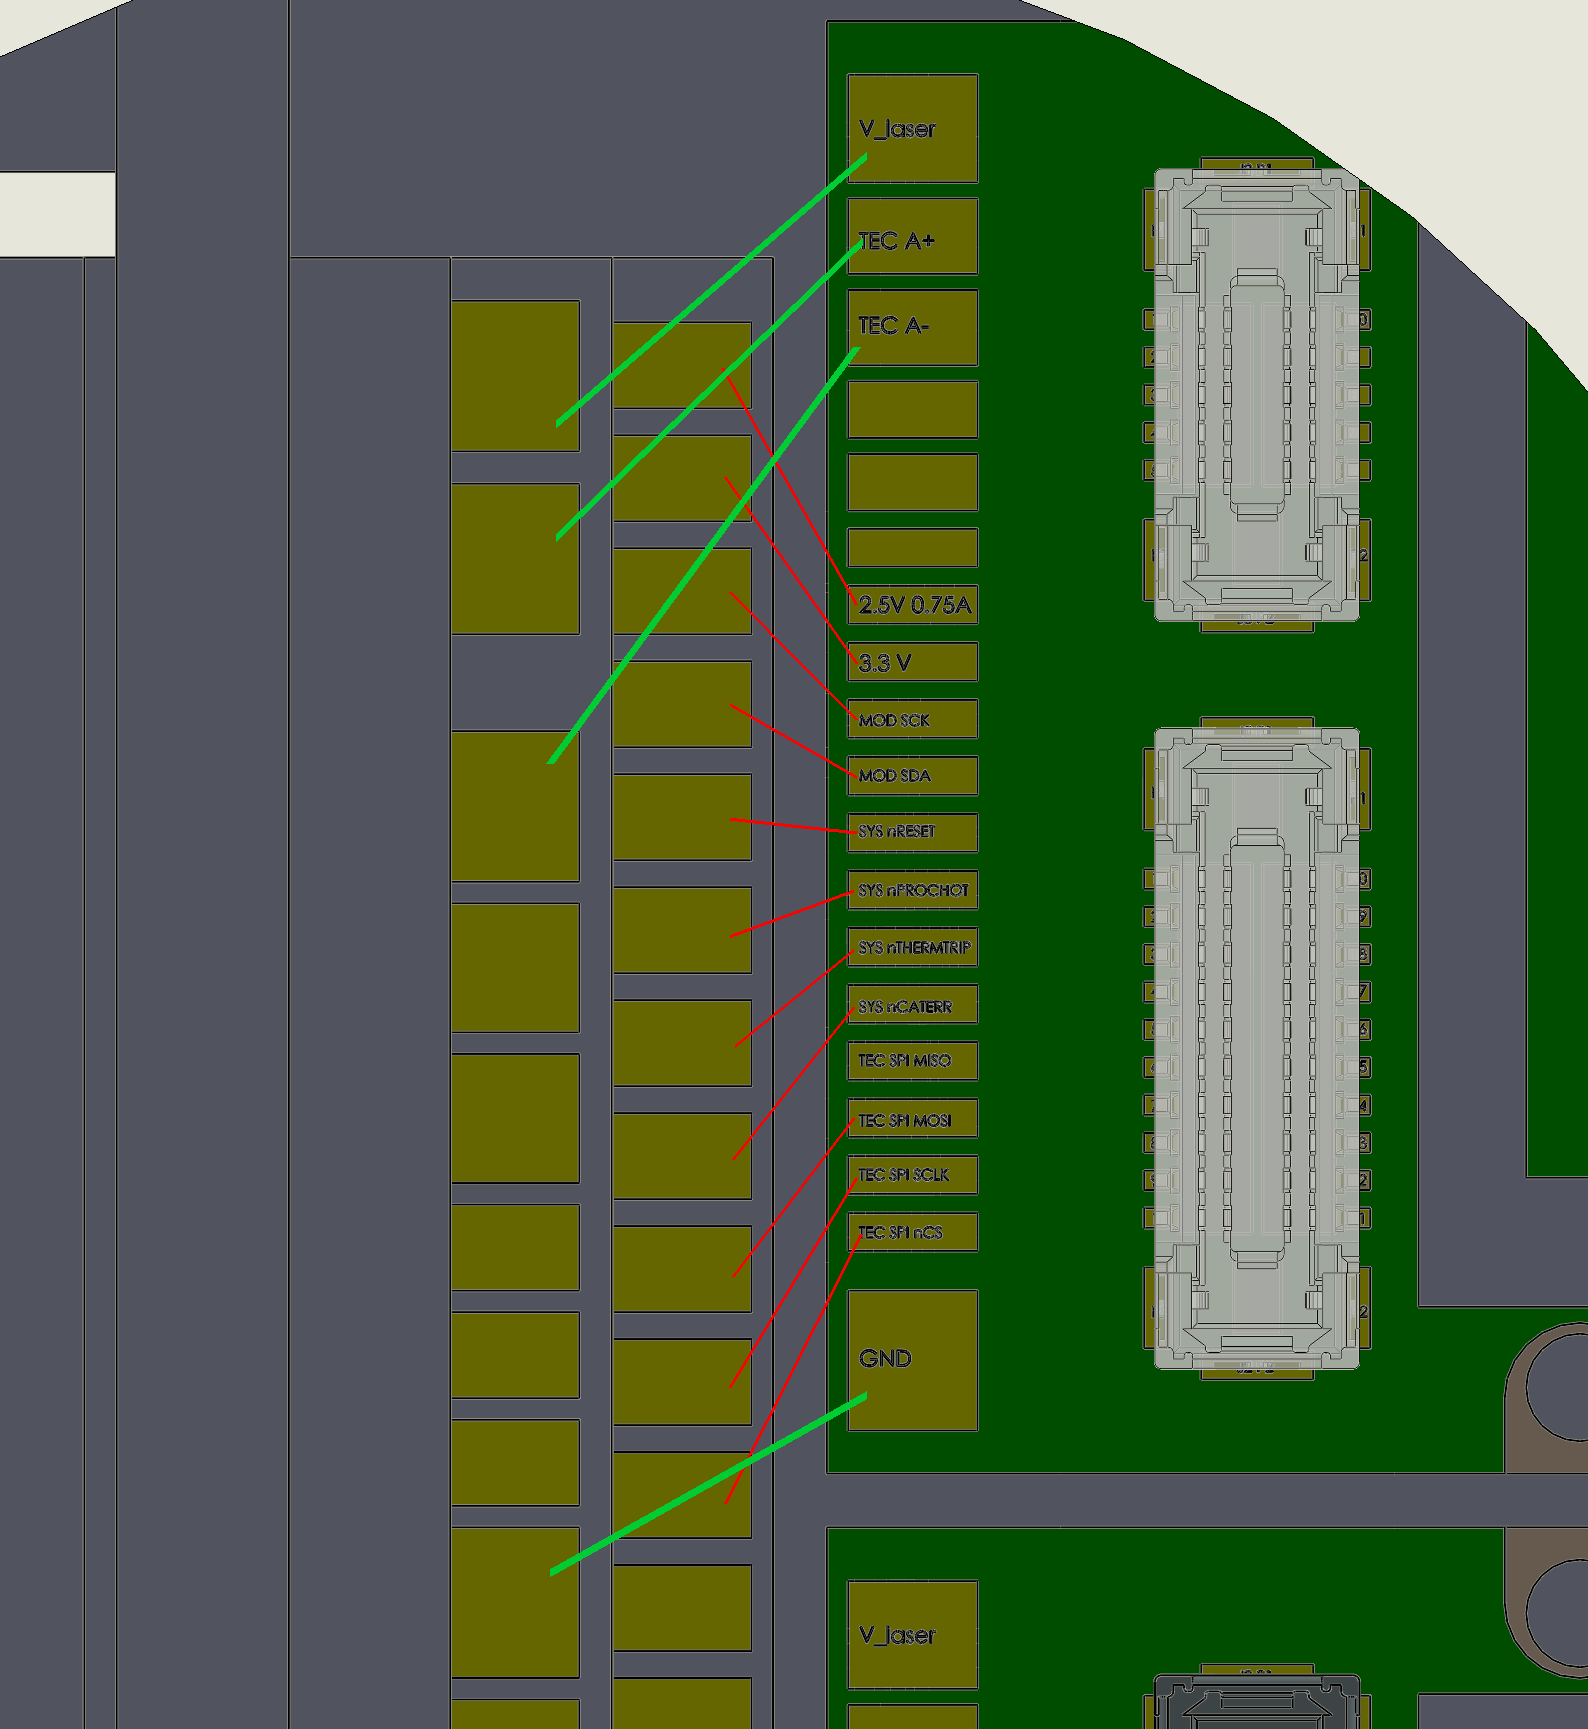

In [41]:
#Wirebond
# 25um diameter gold FP2, 4.58mm length
# Electrical Resistivity 3.24 µ-Ohm-cm
R_wirebond = 3.24e-6*100*4.58e-3/(np.pi*(12.5e-6)**2)/1e3
print('R_wirebond: {:2f} mOhm'.format(R_wirebond))
N_wirebonds = 1
wirebond_drop = R_wirebond/(Npins_per_tile*N_wirebonds)*current/Ntile
IRdrop += wirebond_drop
print('Wirebond Drop: {}mV'.format(wirebond_drop))
print('IR Drop: {}mV'.format(IRdrop))

R_wirebond: 3.023017 mOhm
Wirebond Drop: 13.784957521629947mV
IR Drop: 205.80629626263206mV


In [42]:
# Driver board to PIC 
t = 2.7*25.4e-6 # 1 2.7mil thick layer
met_den = 0.5
rx_sheet = 1/4e7/t/met_den
print(rx_sheet)
ry_sheet = 1/4e7/t/met_den
l = layer(name='pwr',net='pwr',lx=0,ly=0,ux=30e3,uy=25e3,dx=1e3,dy=1e3,rx_sheet=rx_sheet,ry_sheet=ry_sheet)
ld = load(l1=l, l2=None, lx=28e3,ly=0e3,ux=30e3,uy=12.5e3,iload=37/8)
src = sources(l1=l, l2=None, lx=0, ly=0, ux=2e3, uy=2e3, v=1.8)
s = system()
s.layers.append(l)
s.loads.append(ld)
s.sources.append(src)
s.arrange_nodes()
s.fill_matrix()
s.solve()
s.recover()
X, Y, V = plot_voltage_3d(l, filename='driver_brd_pwr.png')
print('Max Voltage: {}V'.format(np.max(V)))
print('Min Voltage: {}V'.format(np.min(V)))
print('Drop: {}mV'.format((np.max(V)-np.min(V))*1e3))
IRdrop += (np.max(V)-np.min(V))*1e3
print('Total IR Drop: {}mV'.format(IRdrop))

0.0007290755322251383


Max Voltage: 1.7999999537600806V
Min Voltage: 1.792057456976584V
Drop: 7.9424967834966775mV
Total IR Drop: 213.74879304612872mV


In [43]:
# Wirebonds on PIC, return wirebonds, IDAC traceback to PIC
R_path = 15 #mOhm (3mOhm per wirebond + 9mOhm for the path)
Nlaser = 8
path_drop = R_path*current/Ntile/Nlaser
IRdrop += path_drop
print('Path Drop: {}mV'.format(path_drop))
print('Total IR Drop: {}mV'.format(IRdrop))



Path Drop: 8.549999999999999mV
Total IR Drop: 222.29879304612874mV


In [44]:
# VSS return
#DRV board
IRdrop += 2.5 # assume 1/3rd the voltage drop on the power side
# Wirebond
IRdrop += wirebond_drop
# Tile level power pins
IRdrop += pin_drop
# Connector
IRdrop += connector_drop
#MRB Board
IRdrop += 5 # Assume 1/10th the voltage drop on the power side
print('Total IR Drop: {}mV'.format(IRdrop))

Total IR Drop: 393.5165505677586mV
